# SVM models

This notebook was run on an Amazon SageMaker ml.c5.4xlarge instance.  

In [1]:
import pandas as pd
import string
import re
import string
import numpy as np
import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer 

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
import pickle_functions as pf

In [3]:
import model_functions as mf

# 1) SVM - weighted 1/3 toxic, 2/3 nontoxic

### Load and shuffle data

In [4]:
train1 = pf.read_pickle(bucket_name='advancedml-koch-mathur-hinkson', 
                        filename='sub_train_df4_preprocessed')

In [5]:
drop_cols = ['split', 'cleaned_w_stopwords', 'cleaned_no_stem', 'cleaned_porter', 'cleaned_lancaster', 
             'bigrams_unstemmed', 'perc_upper', 'num_exclam', 'num_words', 'perc_stopwords', 'num_upper_words']

In [6]:
train1 = train1.drop(drop_cols, axis = 1)

In [7]:
train1.shape

(100000, 49)

In [8]:
train1.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str'],
      dtype='object')

Create a new column called "toxicity_category" in the train data frame categorizing comments as toxic ("1") or non-toxic ("0").

In [9]:
train1['toxicity_category'] = train1.target.apply(lambda x: 1 if x > 0.5 else 0)

Split train.csv into training (80%) and hold out sets (20%).

In [10]:
#Citation: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train1)) < 0.8
train_set1 = train1[msk]
hold_out_set1 = train1[~msk]

In [11]:
print(train_set1.toxicity_category.value_counts())

0    75257
1     4775
Name: toxicity_category, dtype: int64


In [12]:
print(hold_out_set1.toxicity_category.value_counts())

0    18831
1     1137
Name: toxicity_category, dtype: int64


In [13]:
toxic1 = train_set1[train_set1.toxicity_category == 1]
nontoxic1 = train_set1[train_set1.toxicity_category == 0]

In [14]:
train_set1.shape, toxic1.shape, nontoxic1.shape

((80032, 50), (4775, 50), (75257, 50))

Create a data set of 1/3 toxic and 2/3 nontoxic comments, and shuffle the data such that you do not have a data set of grouped toxic and grouped nontoxic comments

In [15]:
prepared_33 = toxic1.append(nontoxic1.sample(len(toxic1)*2))
prepared_33 = prepared_33.sample(frac=1).reset_index(drop=True)
print(prepared_33.toxicity_category.value_counts())

0    9550
1    4775
Name: toxicity_category, dtype: int64


### Run model

In [16]:
classifier1, output1, fitted_vectorizer1 = mf.run_model(model_df=prepared_33, 
                                                     model_type="SVM", 
                                                     comments = "cleaned_no_stem_str", 
                                                     train_perc=0.95, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [17]:
output1.head(5).style

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,cleaned_w_stopwords_str,cleaned_no_stem_str,cleaned_porter_str,cleaned_lancaster_str,toxicity_category,predicted,y_test,accuracy
13609,725180,0,I hope the CRA is keeping track of these under the table businesses and prosecuting them appropriately.,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-18 06:39:13.634671+00,54,nan,157088,approved,0,0,0,9,0,0,0,4,I hope the CRA is keeping track of these under the table businesses and prosecuting them appropriately,i hope cra keeping track under table businesses prosecuting them appropriately,i hope cra keep track under tabl busi prosecut them appropri,i hop cra keep track und tabl busy prosecut them appropry,0,0,0,True
13610,714257,0,We are now .5 or a half point behind the US. Close the gap and the problem will start to resolve itself. Its called monetary economics.,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-12-15 17:55:35.755987+00,54,nan,156750,approved,0,0,0,1,0,0,0,4,We are now 5 or a half point behind the US Close the gap and the problem will start to resolve itself Its called monetary economics,we 5 half point behind us close gap problem start resolve its called monetary economics,we 5 half point behind us close gap problem start resolv it call monetari econom,we 5 half point behind us clos gap problem start resolv it cal monet econom,0,0,0,True
13611,634809,0,"In the context of the City Hall fiasco (and there's no other word for it), this article paints a really damning picture of Eugene's civic leadership (or lack of it). Seems that the improvements in communication cited here have mainly served to facilitate deep rooted dialogues of incompetence, however well intentioned some of the participants may be. How in Heaven's name could people with a modicum of wisdom and foresight allow contradictory, half-baked stabs at decision making to pile up over such long period of time. Oh, sorry, Mr. Ruiz is praised for giving ""clear direction"" on ""some items"" - maybe like where to put a drinking fountain or what color to paint a park bench??? The sad likelihood is that this glowing in-house appraisal will result in a hefty salary increase. But then, without a Ruiz to guide the current cast of characters, how will Eugene be able to stay ahead of 'hot button issues' that abound. Hmmm.",0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-11-29 17:06:00.834481+00,13,nan,153308,approved,0,0,0,4,0,0,0,4,In the context of the City Hall fiasco and there's no other word for it this article paints a really damning picture of Eugene's civic leadership or lack of it Seems that the improvements in communication cited here have mainly served to facilitate deep rooted dialogues of incompetence however well intentioned some of the participants may be How in Heaven's name could people with a modicum of wisdom and foresight allow contradictory half baked stabs at decision making to pile up over such long period of time Oh sorry Mr Ruiz is praised for giving clear direction on some items maybe like where to put a drinking fountain or what color to paint a park bench The sad likelihood is that this glowing in house appraisal will result in a hefty salary increase But then without a Ruiz to guide the current cast of characters how will Eugene be able to stay ahead of hot bu

In [18]:
hold_out_results1 = mf.run_model_test(model_df=hold_out_set1, 
                                     clf=classifier1, 
                                     vectorizer=fitted_vectorizer1, 
                                     comments="cleaned_no_stem_str", target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str', 'toxicity_category', 'predicted', 'y_test'],
      dtype='object')


In [19]:
hold_out_metrics1 = mf.get_metrics(output=hold_out_results1, 
                                   detailed=True, 
                                   should_print=True, 
                                   round_to=3)

Overall Accuracy: 0.9389523237179487
Overall Precision: 0.4747847478474785
Overall Recall: 0.6789797713280563
Overall F1 Score: 0.5588128845457836
ROC_AUC: 0.817

Target Accuracy: 0.6789797713280563
Target Precision: 1.0
Target Recall: 0.6789797713280563
Target F1 Score: 0.8088004190675747

Non-Target Accuracy: 0.95464924857947
Non-Target Precision: 1.0
Non-Target Recall: 0.95464924857947
Non-Target F1 Score: 0.9767985220604216

Strong Identity Accuracy: 0.6338028169014085
Strong Identity Precision: 0.9761904761904762
Strong Identity Recall: 0.6212121212121212
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.7671232876712328
Obscenity Precision: 1.0
Obscenity Recall: 0.7638888888888888
Obscenity F1 Score: 1.0

Insults Accuracy: 0.7373271889400922
Insults Precision: 0.9874411302982732
Insults Recall: 0.7408716136631331
Insults F1 Score: 1.0

Threats Accuracy: 0.4117647058823529
Threats Precision: 1.0
Threats Recall: 0.3939393939393939
Threats F1 Score: 1.0



# 2) SVM - weighted 25% toxic, 75% nontoxic

### Load and shuffle data

In [30]:
train2 = pf.read_pickle(bucket_name='advancedml-koch-mathur-hinkson', filename='sub_train_df7_preprocessed')

In [31]:
drop_cols = ['split', 'cleaned_w_stopwords', 'cleaned_no_stem', 'cleaned_porter', 'cleaned_lancaster', 'bigrams_unstemmed',
       'perc_upper', 'num_exclam', 'num_words', 'perc_stopwords',
       'num_upper_words']

In [32]:
train2 = train2.drop(drop_cols, axis = 1)

In [33]:
train2.shape

(100000, 49)

In [34]:
train2.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str'],
      dtype='object')

Create a new column called "toxicity_category" in the train data frame categorizing comments as toxic ("1") or non-toxic ("0").

In [35]:
train2['toxicity_category'] = train2.target.apply(lambda x: 1 if x > 0.5 else 0)

Split train.csv into training (80%) and hold out sets (20%).

In [36]:
#Citation: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train2)) < 0.8
train_set2 = train2[msk]
hold_out_set2 = train2[~msk]


In [37]:
print(train_set2.toxicity_category.value_counts())

0    75913
1     4188
Name: toxicity_category, dtype: int64


In [38]:
print(hold_out_set2.toxicity_category.value_counts())

0    18899
1     1000
Name: toxicity_category, dtype: int64


In [39]:
toxic2 = train_set2[train_set2.toxicity_category == 1]
nontoxic2 = train_set2[train_set2.toxicity_category == 0]

In [41]:
train_set2.shape, toxic2.shape, nontoxic2.shape

((80101, 50), (4188, 50), (75913, 50))

Create a data set of 25% toxic and 75% nontoxic comments, and shuffle the data such that you do not have a data set of grouped toxic and grouped nontoxic comments

In [42]:
prepared_25 = toxic2.append(nontoxic2.sample(len(toxic2)*3))
prepared_25 = prepared_25.sample(frac=1).reset_index(drop=True)
print(prepared_25.toxicity_category.value_counts())

0    12564
1     4188
Name: toxicity_category, dtype: int64


## Run model

In [43]:
classifier2, output2, fitted_vectorizer2 = mf.run_model(model_df=prepared_25, 
                                                     model_type="SVM", 
                                                     comments = "cleaned_no_stem_str", 
                                                     train_perc=0.95, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [44]:
output2.head(10).style

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,cleaned_w_stopwords_str,cleaned_no_stem_str,cleaned_porter_str,cleaned_lancaster_str,toxicity_category,predicted,y_test,accuracy
15914,1051887,0,"They probably could have found a large part of the funds they wanted just by being a little creative. Give up one leg of the nuclear deterrent triad. Enormous savings. The reliability and utility of the strategic nuclear bombing mission has been in question for decades, it's just that no one has had the political gumption to put down that sacred cow. In a $600B institution you know there will be a number of outdated bureaucratic empires and capabilities that could be chopped or re-invented. Instead the simpleton will just try to fill a bottomless pit with more money.",0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2017-02-27 17:42:56.766069+00,54,nan,315400,approved,0,0,0,0,0,0,0,4,They probably could have found a large part of the funds they wanted just by being a little creative Give up one leg of the nuclear deterrent triad Enormous savings The reliability and utility of the strategic nuclear bombing mission has been in question for decades it's just that no one has had the political gumption to put down that sacred cow In a 600B institution you know there will be a number of outdated bureaucratic empires and capabilities that could be chopped or re invented Instead the simpleton will just try to fill a bottomless pit with more money,they probably could found large part funds wanted little creative give one leg nuclear deterrent triad enormous savings the reliability utility strategic nuclear bombing mission question decades one political gumption put sacred cow in 600b institution know number outdated bureaucratic empires capabilities could chopped invented instead simpleton try fill bottomless pit money,they probabl could found larg part fund want littl creativ give one leg nuclear deterr triad enorm save the reliabl util strateg nuclear bomb mission question decad one polit gumption put sacr cow in 600b institut know number outdat bureaucrat empir capabl could chop invent instead simpleton tri fill bottomless pit money,they prob could found larg part fund want littl cre giv on leg nuclear deter triad enorm sav the rely util strategic nuclear bomb miss quest decad on polit gumpt put sacr cow in 600b institut know numb outd bureaucr empir cap could chop inv instead simpleton try fil bottomless pit money,0,0,0,True
15915,1079167,0.4,"Trump's ""put his life at risk"" for Latinos, Hispanics and Mexicans? Gee, how did I miss the YUGE headlines when that happened? That's the funniest - and most stupid - thing I've read all day. Seriously.",0,0.2,0.3,0.5,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0.9,0.2,0,0,0,0.1,0,0,0,0,0,0,2017-03-05 02:33:54.837477+00,21,nan,316938,approved,1,0,0,9,0,0,10,10,Trump's put his life at risk for Latinos Hispanics and Mexicans Gee how did I miss the YUGE headlines when that happened That's the funniest and most stupid thing I've read all day Seriously,trump's put life risk latinos hispanics mexicans gee i miss yuge headlines happened that's funniest stupid thing i've read day seriously,trump' put life risk latino hispan mexican gee i miss yuge headlin happen that' funniest stupid thing i'v read day serious,trump's put lif risk latino hisp mex gee i miss yug headlin hap that's funniest stupid thing i've read day sery,0,1,0,False
15916,1011522,0.805195,"Easy for silver s

In [45]:
mf.get_metrics(output=output2, 
               detailed=True, 
               should_print=True, 
               round_to=3)


Overall Accuracy: 0.8770883054892601
Overall Precision: 0.9121621621621622
Overall Recall: 0.6
Overall F1 Score: 0.7238605898123324
ROC_AUC: 0.789

Target Accuracy: 0.6
Target Precision: 1.0
Target Recall: 0.6
Target F1 Score: 0.7499999999999999

Non-Target Accuracy: 0.9787928221859706
Non-Target Precision: 1.0
Non-Target Recall: 0.9787928221859706
Non-Target F1 Score: 0.9892827699917559

Strong Identity Accuracy: 0.5789473684210527
Strong Identity Precision: 1.0
Strong Identity Recall: 0.5789473684210527
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.6153846153846154
Obscenity Precision: 0.8888888888888888
Obscenity Recall: 0.6666666666666666
Obscenity F1 Score: 1.0

Insults Accuracy: 0.6804733727810651
Insults Precision: 1.0
Insults Recall: 0.6804733727810651
Insults F1 Score: 1.0

Threats Accuracy: 0.25
Threats Precision: 1.0
Threats Recall: 0.25
Threats F1 Score: 0.0



{'Overall': {'Accuracy': 0.8770883054892601,
  'Precision': 0.9121621621621622,
  'Recall': 0.6,
  'F1': 0.7238605898123324,
  'ROC_AUC': 0.789},
 'Target': {'Accuracy': 0.6,
  'Precision': 1.0,
  'Recall': 0.6,
  'F1': 0.7499999999999999},
 'Non-Target': {'Accuracy': 0.25, 'Precision': 1.0, 'Recall': 0.25, 'F1': 0.0}}

In [46]:
hold_out_results2 = mf.run_model_test(model_df=hold_out_set2, 
                                     clf=classifier2, 
                                     vectorizer=fitted_vectorizer2, 
                                     comments="cleaned_no_stem_str",
                                      target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str', 'toxicity_category', 'predicted', 'y_test'],
      dtype='object')


In [47]:
hold_out_metrics2 = mf.get_metrics(output=hold_out_results2, 
                                   detailed=True, 
                                   should_print=True, 
                                   round_to=3)

Overall Accuracy: 0.953012714206744
Overall Precision: 0.5290957923008057
Overall Recall: 0.591
Overall F1 Score: 0.5583372697213037
ROC_AUC: 0.782

Target Accuracy: 0.591
Target Precision: 1.0
Target Recall: 0.591
Target F1 Score: 0.742928975487115

Non-Target Accuracy: 0.9721678395682312
Non-Target Precision: 1.0
Non-Target Recall: 0.9721678395682312
Non-Target F1 Score: 0.985887529512771

Strong Identity Accuracy: 0.5476190476190477
Strong Identity Precision: 1.0
Strong Identity Recall: 0.4794520547945205
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.5737704918032787
Obscenity Precision: 1.0
Obscenity Recall: 0.5517241379310345
Obscenity F1 Score: 1.0

Insults Accuracy: 0.6826923076923077
Insults Precision: 0.9918032786885246
Insults Recall: 0.680731364275668
Insults F1 Score: 1.0

Threats Accuracy: 0.2857142857142857
Threats Precision: 0.8
Threats Recall: 0.2222222222222222
Threats F1 Score: 0.0



### Feature Importance

In [48]:
feature_names = fitted_vectorizer2.get_feature_names()
imp = classifier2.coef_.todense().tolist()[0]
imp2, names = zip(*sorted(zip(imp,feature_names)))

In [49]:
imps = imp2[-10:] + imp2[:10]
words = names[-10:] + names[:10]

In [50]:
tograph = pd.DataFrame()
tograph['importances'] = imps
tograph['words'] = words
tograph['type'] = tograph.importances.apply(lambda x: 1 if x > 0 else 0)

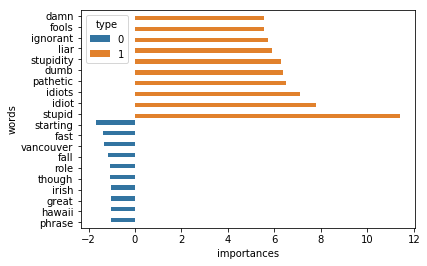

In [51]:
sns.barplot(x="importances", y="words", data=tograph, hue="type")

# 3) SVM - weighted 25% toxic, 75% nontoxic; using porter

In [52]:
train3 = pf.read_pickle(bucket_name='advancedml-koch-mathur-hinkson', filename='sub_train_df1_preprocessed')

In [53]:
drop_cols = ['split', 'cleaned_w_stopwords', 'cleaned_no_stem', 'cleaned_porter', 'cleaned_lancaster', 
             'bigrams_unstemmed', 'perc_upper', 'num_exclam', 'num_words', 'perc_stopwords',
             'num_upper_words']

In [54]:
train3 = train3.drop(drop_cols, axis = 1)

In [55]:
train3.shape

(100000, 49)

In [56]:
train3.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str'],
      dtype='object')

Create a new column called "toxicity_category" in the train data frame categorizing comments as toxic ("1") or non-toxic ("0").

In [57]:
train3['toxicity_category'] = train3.target.apply(lambda x: 1 if x > 0.5 else 0)

Split train.csv into training (80%) and hold out sets (20%).

In [58]:
#Citation: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(train3)) < 0.8
train_set3 = train3[msk]
hold_out_set3 = train3[~msk]


In [59]:
print(train_set3.toxicity_category.value_counts())

0    75938
1     4105
Name: toxicity_category, dtype: int64


In [60]:
print(hold_out_set3.toxicity_category.value_counts())

0    18928
1     1029
Name: toxicity_category, dtype: int64


In [61]:
toxic3 = train_set3[train_set3.toxicity_category == 1]
nontoxic3 = train_set3[train_set3.toxicity_category == 0]

In [62]:
train_set3.shape, toxic3.shape, nontoxic3.shape

((80043, 50), (4105, 50), (75938, 50))

Create a data set of 25% toxic and 75% nontoxic comments, and shuffle the data such that you do not have a data set of grouped toxic and grouped nontoxic comments

In [63]:
prepared_25_b = toxic3.append(nontoxic3.sample(len(toxic3)*3))
prepared_25_b = prepared_25_b.sample(frac=1).reset_index(drop=True)
print(prepared_25_b.toxicity_category.value_counts())

0    12315
1     4105
Name: toxicity_category, dtype: int64


### Run model

In [64]:
classifier3, output3, fitted_vectorizer3 = mf.run_model(model_df=prepared_25_b, 
                                                     model_type="SVM", 
                                                     comments = "cleaned_porter_str", 
                                                     train_perc=0.95, 
                                                     target="toxicity_category", 
                                                     see_inside=False)

fitting model now


In [65]:
output3.head(10).style

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,cleaned_w_stopwords_str,cleaned_no_stem_str,cleaned_porter_str,cleaned_lancaster_str,toxicity_category,predicted,y_test,accuracy
15599,355663,0,"Hey Marvin, how about a 20% income tax on everyone, isn't that tantamount to a salary reduction? Why not share the burden equally? Or does that hit too close to home?",0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-06-18 19:01:41.544273+00,21,355429,139044,approved,0,0,0,1,0,0,0,4,Hey Marvin how about a 20 income tax on everyone isn't that tantamount to a salary reduction Why not share the burden equally Or does that hit too close to home,hey marvin 20 income tax everyone tantamount salary reduction why not share burden equally or hit close home,hey marvin 20 incom tax everyon tantamount salari reduct whi not share burden equal or hit close home,hey marvin 20 incom tax everyon tantamount sal reduc why not shar burd eq or hit clos hom,0,0,0,True
15600,330234,0,"The advisory group (and perhaps others, but not ""Kuskokwim River residents"" as implied in the article) agreed to support limiting fishing, when decisions were easy, during winter. Now it's crunch time, and they whine and cry to the Department going against what they supported. Real leaders, real people, would man up and help support the hard decisions that they themselves agreed need to be made. Deferring the hard decisions to the Department seems to be an attempt to deflect the heat; let someone else take the blame. Shame.",0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2016-05-28 06:19:57.656068+00,21,nan,137616,approved,0,0,0,2,0,0,0,4,The advisory group and perhaps others but not Kuskokwim River residents as implied in the article agreed to support limiting fishing when decisions were easy during winter Now it's crunch time and they whine and cry to the Department going against what they supported Real leaders real people would man up and help support the hard decisions that they themselves agreed need to be made Deferring the hard decisions to the Department seems to be an attempt to deflect the heat let someone else take the blame Shame,the advisory group perhaps others not kuskokwim river residents implied article agreed support limiting fishing decisions easy winter now crunch time whine cry department going against supported real leaders real people would man help support hard decisions themselves agreed need made deferring hard decisions department seems attempt deflect heat let someone else take blame shame,the advisori group perhap other not kuskokwim river resid impli articl agre support limit fish decis easi winter now crunch time whine cri depart go against support real leader real peopl would man help support hard decis themselv agre need made defer hard decis depart seem attempt deflect heat let someon els take blame shame,the adv group perhap oth not kuskokwim riv resid imply artic agree support limit fish decid easy wint now crunch tim whin cry depart going against support real lead real peopl would man help support hard decid themselv agree nee mad defer hard decid depart seem attempt deflect heat let someon els tak blam sham,0,0,0,True
15601,330277,0.2,"Let none of us fail to understand that the real harm done by these scammers is that they obscure from our view people who are truly in need. They are fraudsters - pretending to be the needy. Th

In [66]:
mf.get_metrics(output=output3, 
               detailed=True, 
               should_print=True, 
               round_to=3)

Overall Accuracy: 0.8855054811205847
Overall Precision: 0.8775510204081632
Overall Recall: 0.6292682926829268
Overall F1 Score: 0.7329545454545454
ROC_AUC: 0.8

Target Accuracy: 0.6292682926829268
Target Precision: 1.0
Target Recall: 0.6292682926829268
Target F1 Score: 0.7724550898203593

Non-Target Accuracy: 0.9707792207792207
Non-Target Precision: 1.0
Non-Target Recall: 0.9707792207792207
Non-Target F1 Score: 0.985172981878089

Strong Identity Accuracy: 0.6
Strong Identity Precision: 1.0
Strong Identity Recall: 0.6
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.7894736842105263
Obscenity Precision: 1.0
Obscenity Recall: 0.7894736842105263
Obscenity F1 Score: 1.0

Insults Accuracy: 0.6510067114093959
Insults Precision: 0.9897959183673469
Insults Recall: 0.6554054054054054
Insults F1 Score: 1.0

Threats Accuracy: 0.2857142857142857
Threats Precision: 1.0
Threats Recall: 0.2857142857142857
Threats F1 Score: 0.0



{'Overall': {'Accuracy': 0.8855054811205847,
  'Precision': 0.8775510204081632,
  'Recall': 0.6292682926829268,
  'F1': 0.7329545454545454,
  'ROC_AUC': 0.8},
 'Target': {'Accuracy': 0.6292682926829268,
  'Precision': 1.0,
  'Recall': 0.6292682926829268,
  'F1': 0.7724550898203593},
 'Non-Target': {'Accuracy': 0.2857142857142857,
  'Precision': 1.0,
  'Recall': 0.2857142857142857,
  'F1': 0.0}}

In [67]:
hold_out_results3 = mf.run_model_test(model_df=hold_out_set3, 
                                     clf=classifier3, 
                                     vectorizer=fitted_vectorizer3, 
                                     comments="cleaned_no_stem_str", target="toxicity_category")

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count',
       'cleaned_w_stopwords_str', 'cleaned_no_stem_str', 'cleaned_porter_str',
       'cleaned_lancaster_str', 'toxicity_category', 'predicted', 'y_test'],
      dtype='object')


In [68]:
hold_out_metrics3 = mf.get_metrics(output=hold_out_results3, 
                                   detailed=True, 
                                   should_print=True, 
                                   round_to=3)

Overall Accuracy: 0.952698301347898
Overall Precision: 0.5596072931276297
Overall Recall: 0.3877551020408163
Overall F1 Score: 0.4580941446613088
ROC_AUC: 0.686

Target Accuracy: 0.3877551020408163
Target Precision: 1.0
Target Recall: 0.3877551020408163
Target F1 Score: 0.5588235294117647

Non-Target Accuracy: 0.9834108199492815
Non-Target Precision: 1.0
Non-Target Recall: 0.9834108199492815
Non-Target F1 Score: 0.9916360343082414

Strong Identity Accuracy: 0.48148148148148145
Strong Identity Precision: 1.0
Strong Identity Recall: 0.44
Strong Identity F1 Score: 1.0

Obscenity Accuracy: 0.546875
Obscenity Precision: 1.0
Obscenity Recall: 0.5433070866141733
Obscenity F1 Score: 1.0

Insults Accuracy: 0.4266487213997308
Insults Precision: 0.9933993399339934
Insults Recall: 0.41517241379310343
Insults F1 Score: 1.0

Threats Accuracy: 0.21052631578947367
Threats Precision: 1.0
Threats Recall: 0.1891891891891892
Threats F1 Score: 0.0



### Feature Importance

In [69]:
feature_names = fitted_vectorizer3.get_feature_names()
imp = classifier3.coef_.todense().tolist()[0]
imp2, names = zip(*sorted(zip(imp,feature_names)))


In [70]:
imps = imp2[-10:] + imp2[:10]
words = names[-10:] + names[:10]

In [71]:
tograph = pd.DataFrame()
tograph['importances'] = imps
tograph['words'] = words
tograph['type'] = tograph.importances.apply(lambda x: 1 if x > 0 else 0)

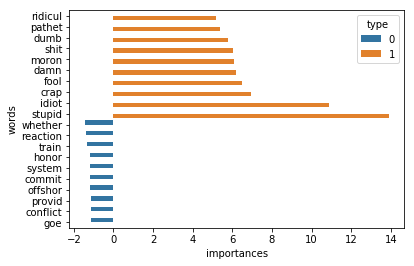

In [72]:
sns.barplot(x="importances", y="words", data=tograph, hue="type")